In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal


import numpy as np



from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [2]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500

mi_hidden1_dim = 240
mi_hidden2_dim = 240


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.
beta_start = beta
beta_end = 1.
total_step = 500
beta_delta = (beta_end-beta_start)/total_step


save_folder = 'SGD-infomax'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

qn_value =0

infomax_alpha = 10.

In [3]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [4]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c,inv_sm_pi_c

In [5]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [6]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [7]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


#optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,inv_sm_pi_c_g],lr=0.002)
optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

In [9]:
'''

class MI_MLP(nn.Module):
    def __init__(self):
        super(MI_MLP, self).__init__()

        self.input_layer = nn.Linear(input_dim+latent_dim,mi_hidden1_dim)##728 => 500 for MNIST
        self.hidden1_layer = nn.Linear(mi_hidden1_dim,mi_hidden2_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(mi_hidden2_dim,1)##500 => 2000 for MNIST

    def forward(self, x_and_z):
        h1 = F.relu(self.input_layer(x_and_z))
        h2 = F.relu(self.hidden1_layer(h1))

        return torch.sigmoid(self.output_layer(h2))
    #出力はxの予測値とzを算出するときの中心と分散になっている


MI_model = MI_MLP().to(device)

optimizer_mi = optim.Adam(MI_model.parameters(),lr=0.002)
scheduler_mi = torch.optim.lr_scheduler.MultiStepLR(optimizer_mi,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)
'''

'\n\nclass MI_MLP(nn.Module):\n    def __init__(self):\n        super(MI_MLP, self).__init__()\n\n        self.input_layer = nn.Linear(input_dim+latent_dim,mi_hidden1_dim)##728 => 500 for MNIST\n        self.hidden1_layer = nn.Linear(mi_hidden1_dim,mi_hidden2_dim)##500 => 500 for MNIST\n        self.output_layer = nn.Linear(mi_hidden2_dim,1)##500 => 2000 for MNIST\n\n    def forward(self, x_and_z):\n        h1 = F.relu(self.input_layer(x_and_z))\n        h2 = F.relu(self.hidden1_layer(h1))\n\n        return torch.sigmoid(self.output_layer(h2))\n    #出力はxの予測値とzを算出するときの中心と分散になっている\n\n\nMI_model = MI_MLP().to(device)\n\noptimizer_mi = optim.Adam(MI_model.parameters(),lr=0.002)\nscheduler_mi = torch.optim.lr_scheduler.MultiStepLR(optimizer_mi,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)\n'

In [10]:

class MI_MLP(nn.Module):
    def __init__(self):
        super(MI_MLP, self).__init__()

        self.input_layer = nn.Linear(input_dim+latent_dim,mi_hidden1_dim)##728 => 500 for MNIST
        self.hidden1_layer = nn.Linear(mi_hidden1_dim,mi_hidden2_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(mi_hidden2_dim,1)##500 => 2000 for MNIST

    def forward(self, x_and_z):
        h1 = F.elu(self.input_layer(x_and_z))
        h2 = F.elu(self.hidden1_layer(h1))

        return self.output_layer(h2)
    #出力はxの予測値とzを算出するときの中心と分散になっている


MI_model = MI_MLP().to(device)

optimizer_mi = optim.Adam(MI_model.parameters(),lr=0.0002)
scheduler_mi = torch.optim.lr_scheduler.MultiStepLR(optimizer_mi,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [11]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [12]:
def gauss(mus,logvars,mu_c,logvar_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [13]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [14]:
def show_generated_samples_c(mu_c,logvar_c):
    for i in range(K_model_cluster):
        with torch.no_grad():
            sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

In [15]:
def q_exponential(x,n):
    if n==0:
        return x.exp()
    else:
        return (1. - x/n).pow(-n)

def q_log(x,n):
    if n==0:
        return x.log()
    else:
        return n*(x.pow(1./n)-1.)

In [16]:
def shuffle_cat(x,z):
    tz = torch.randperm(latent_dim)
    return torch.cat([x(-1,input_dim),z[:,tz]],dim=1)

In [17]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f,z):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,input_dim),reduction='sum')
    KLD = -(q_log((F.softmax(inv_sm_pi_c_f,dim=2)*(q_exponential(-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True)),qn_value))).sum(2,keepdim=True),qn_value)).sum()
    MI = (MI_model(torch.cat([x.view(-1,input_dim),z],dim=1))-(MI_model(torch.cat([x.view(-1,input_dim),z[torch.randperm(batch_size),:]],dim=1))-1.).exp()).sum()
#    KLD = -(((F.softmax(inv_sm_pi_c_f,dim=2)*((-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).sum()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD-infomax_alpha*MI

In [18]:
def train_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        optimizer_mi.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z_data = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c,z=z_data)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        optimizer_mi.step()
        #MI_MLPの更新

#        print(mu_c_g)
#        print('var_c='.format(logvar_c_g.exp()))

#        print('mu={}'.format(mu.view(-1,latent_dim,1).squeeze()))
#        print('prec_c={}'.format((1./logvar_c_g.exp()).squeeze()))
#        print('quad={}'.format(((((mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('quadvar={}'.format((((logvar.view(-1,latent_dim,1).exp())/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('expDKL={}'.format((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp().squeeze()))
#        print('logDKL={}'.format((((F.softmax(inv_sm_pi_c_g,dim=2)*((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).squeeze()))

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break

In [19]:
def test_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z_data = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c,z=z_data).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [20]:
def train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [21]:

mu_c_g,logvar_c_g,F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[ 0.1253,  0.4156, -0.5116,  1.2595,  0.9449, -0.3832, -0.4497,
            0.1261, -0.2252,  2.1444],
          [-0.5140, -0.9631, -0.2781,  0.5676, -0.9896,  0.9176,  0.3167,
           -0.5226, -1.0699, -1.3057],
          [-2.9883, -0.3983, -1.1811, -1.1120, -1.3389,  1.5144, -1.5289,
           -0.8110, -1.0453, -1.7558],
          [ 0.5161,  3.5164,  1.6547, -0.7244,  0.4444,  0.4308,  0.7442,
            0.6143,  0.8675, -0.0389],
          [ 0.3389, -0.6457, -0.9585,  1.1466, -0.4375, -1.4555,  1.5328,
           -0.6412,  0.6605, -2.1322],
          [ 0.0937, -1.0781, -0.9495,  0.8178,  0.7850,  0.9593,  1.2652,
            0.3977, -0.8257,  0.4051],
          [ 0.8352, -0.6841,  0.0721,  0.5499,  0.4097,  1.0574,  0.5719,
            1.3571,  1.1121,  0.2202],
          [-0.3869,  0.9040,  0.9154, -0.4179,  0.8457,  0.5181,  0.1907,
           -0.2767,  1.5869, -0.7556],
          [-0.9828,  0.6707,  0.2960,  1.8229, -0.7451,  1.3287,  0.0200,
            0.9622, -0

In [22]:
#infomax_alpha = 2.

In [125]:
for i in range(350):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()
    scheduler_mi.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 49.554492
====> Test set loss: 0.7178
Train Epoch: 1 [0/60000 (0%)]	Loss: 71.525830
====> Test set loss: 0.8557
Train Epoch: 2 [0/60000 (0%)]	Loss: 47.535933
====> Test set loss: 0.8011
Train Epoch: 3 [0/60000 (0%)]	Loss: 56.896919
====> Test set loss: 0.5706
Train Epoch: 4 [0/60000 (0%)]	Loss: 60.314058
====> Test set loss: 0.6026
Train Epoch: 5 [0/60000 (0%)]	Loss: 55.777837
====> Test set loss: 0.6710
Train Epoch: 6 [0/60000 (0%)]	Loss: 68.396177
====> Test set loss: 0.7073
Train Epoch: 7 [0/60000 (0%)]	Loss: 52.111172
====> Test set loss: 0.6734
Train Epoch: 8 [0/60000 (0%)]	Loss: 61.275220
====> Test set loss: 0.8529
Train Epoch: 9 [0/60000 (0%)]	Loss: 59.015918
====> Test set loss: 0.5900
Train Epoch: 10 [0/60000 (0%)]	Loss: 69.643457
====> Test set loss: 0.6181
Train Epoch: 11 [0/60000 (0%)]	Loss: 72.323101
====> Test set loss: 0.5944
Train Epoch: 12 [0/60000 (0%)]	Loss: 54.527954
====> Test set loss: 0.7066
Train Epoch: 13 [0/60000 (0%)]	Loss

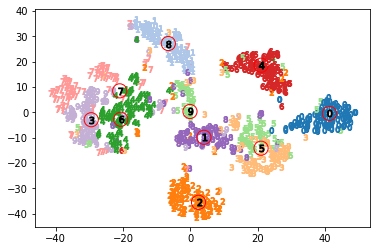

In [126]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

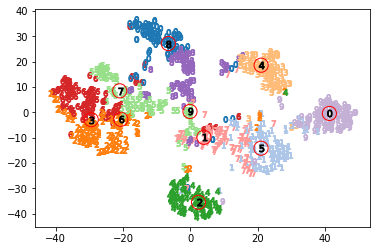

In [127]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

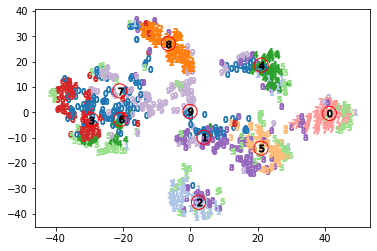

In [128]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

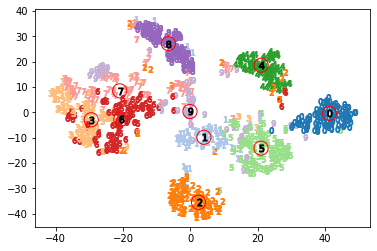

In [129]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,inv_sm_pi_c_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [130]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [131]:
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0005083731656658001, 0.0005083731656658001, 1.0)

In [132]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [133]:
correspond_matrix

tensor([[100.,   0.,   1.,   0.,   0.,   2.,   1.,   0.,   0.,   2.],
        [  0.,   4.,   0.,   0.,   0.,   0.,   0.,   2., 104.,   0.],
        [  0.,   5., 109.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
        [  0.,   3.,   1.,   2.,   0.,  78.,   0.,   2.,   1.,  10.],
        [  0.,   0.,   0.,  16.,   1.,   0.,  69.,  23.,   0.,   0.],
        [  2.,   2.,   0.,   5.,   2.,  34.,   0.,  13.,   0.,  24.],
        [  0.,   0.,   2.,   0.,  89.,   0.,   3.,   5.,   0.,   1.],
        [  0.,   2.,   2.,  33.,   0.,   0.,   3.,  35.,   0.,  17.],
        [  0.,  63.,   1.,   0.,   0.,   5.,   3.,   5.,   0.,   4.],
        [  0.,   1.,   0.,  49.,   0.,   2.,  28.,  21.,   0.,   6.]])

In [134]:
correspond_matrix.sum()

tensor(1000.)

In [135]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([100.,  63., 109.,  49.,  89.,  78.,  69.,  35., 104.,  24.]),
indices=tensor([0, 8, 2, 9, 6, 3, 4, 7, 1, 5]))

In [136]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.7200)

In [137]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [138]:
mu_c_g

tensor([[[-3.3106e-02, -6.2149e-02, -3.9231e-02, -5.7344e-02, -4.9488e-02,
          -5.4495e-02, -5.2402e-02, -5.2529e-02, -4.9722e-02, -5.5787e-02],
         [-6.8042e-02, -1.0665e-01, -7.5512e-02, -1.0575e-01, -9.1553e-02,
          -1.0092e-01, -8.8186e-02, -9.6073e-02, -9.0087e-02, -9.9431e-02],
         [-1.2790e+01, -1.3517e+01, -6.0307e+00, -7.2010e+00, -9.1961e+00,
          -1.3023e+01, -1.0549e+01, -5.5734e+00,  3.2260e-01, -1.0197e+01],
         [ 1.0770e+01,  2.3329e+00,  7.4911e+00, -6.2270e+00,  2.5385e-01,
          -1.7207e+00, -4.3677e-01,  2.5237e+00,  2.6009e-01,  4.5841e+00],
         [ 5.4515e-02,  1.1898e-01,  7.4231e-02,  1.3457e-01,  7.8983e-02,
           9.8317e-02,  1.0329e-01,  1.1383e-01,  1.0335e-01,  1.1258e-01],
         [ 3.2461e+00, -5.6520e+00, -9.2280e+00,  4.0724e+00,  2.6701e+00,
          -8.0767e+00,  7.3543e+00,  5.0548e-02, -4.4877e+00, -1.1859e+00],
         [ 2.0324e-02,  3.0971e-02,  2.3460e-02,  2.6763e-02,  4.6387e-02,
           2.7872e-

In [139]:
logvar_c_g.exp()

tensor([[[ 0.1979,  0.1957,  0.1938,  0.1959,  0.1949,  0.2005,  0.1947,
           0.1922,  0.1889,  0.1960],
         [ 0.2557,  0.2536,  0.2477,  0.2540,  0.2462,  0.2527,  0.2516,
           0.2490,  0.2532,  0.2539],
         [20.8757, 33.3131, 19.9506, 10.9060, 11.8646, 21.5216, 14.4252,
           8.6747,  0.3586, 20.1958],
         [53.8112, 62.6781, 72.9889, 13.9957, 22.9991, 40.6819, 37.9552,
          54.2123, 49.4659, 43.9826],
         [ 0.3175,  0.3216,  0.3125,  0.3376,  0.2995,  0.3184,  0.3202,
           0.3251,  0.3255,  0.3289],
         [ 8.3861,  6.4551, 43.8865, 16.5960,  6.4023, 22.3547, 10.1100,
          16.3021,  2.5350, 29.9778],
         [ 0.1770,  0.1776,  0.1727,  0.1780,  0.1761,  0.1771,  0.1785,
           0.1756,  0.1738,  0.1773],
         [14.0725,  5.3625, 20.5846, 20.0579,  9.7006, 13.1418, 19.2368,
          12.8432,  2.6694,  6.6977],
         [19.5609, 19.3927, 29.1268, 37.8676, 15.9181, 30.1432, 15.3830,
          56.5684,  6.0587, 90.0760],
 

In [140]:
mus_g[0:10,:,0]

tensor([[-4.4492e-02, -8.1721e-02, -1.4681e+01,  1.3846e+00,  9.1893e-02,
          5.1401e+00,  4.0048e-02,  3.4811e+00, -1.2513e+01, -4.3527e+00],
        [ 1.4670e-02,  5.8413e-03, -7.2007e+00,  5.5909e+00, -2.2990e-02,
          7.3740e-01,  1.3011e-02,  6.5706e+00,  1.0161e+01, -6.8501e+00],
        [-2.2137e-02, -7.0803e-02, -6.9214e+00, -5.2498e+00,  7.5485e-02,
          2.6907e+00,  4.2236e-02,  5.9193e-01,  4.9433e+00,  1.7703e+00],
        [-1.6901e-02, -1.2274e-01, -6.8671e+00,  1.4198e+01,  9.0591e-02,
          2.8391e+00,  6.5001e-02, -5.5127e+00, -1.4806e+01,  1.7156e+01],
        [ 1.1862e-02, -5.3719e-02, -2.1223e+01,  1.9816e+01, -1.9084e-02,
          3.5230e+00,  3.0783e-02, -6.9968e+00, -1.0194e+01,  6.4435e+00],
        [ 4.6785e-03, -6.6963e-02, -3.2958e+00,  1.0344e+01,  4.1097e-02,
         -1.2811e+01,  4.8486e-02,  1.2894e+01,  1.5764e+00,  5.1717e+00],
        [-3.5292e-02, -7.6045e-02, -1.7456e+01,  1.8076e+00,  8.8397e-02,
         -7.3383e+00,  5.5529e-0

In [141]:
logvars_g.exp()[0:10,:,0]

tensor([[0.1967, 0.2519, 0.5032, 0.3052, 0.3021, 0.1974, 0.1844, 0.1351, 0.4706,
         0.3922],
        [0.1758, 0.2189, 0.1548, 0.1891, 0.2710, 0.1173, 0.1654, 0.1451, 0.1109,
         0.1625],
        [0.1799, 0.2289, 0.1704, 0.1663, 0.2871, 0.1375, 0.1746, 0.0857, 0.1429,
         0.1585],
        [0.1904, 0.2566, 0.2175, 0.3549, 0.3087, 0.2394, 0.1750, 0.2740, 0.7687,
         0.4196],
        [0.1910, 0.2451, 0.5841, 0.4080, 0.3097, 0.1580, 0.1720, 0.3442, 0.4075,
         0.3930],
        [0.1923, 0.2436, 0.2310, 0.4317, 0.2905, 0.3126, 0.1786, 0.3543, 0.3082,
         0.3384],
        [0.1921, 0.2275, 0.4439, 0.2620, 0.3155, 0.1241, 0.1832, 0.1573, 0.2100,
         0.3362],
        [0.1931, 0.2438, 0.1914, 0.2321, 0.3176, 0.1475, 0.1789, 0.1674, 0.1236,
         0.2484],
        [0.1847, 0.2340, 0.2379, 0.2119, 0.3153, 0.2081, 0.1737, 0.1619, 0.1958,
         0.2324],
        [0.1930, 0.2601, 0.2331, 0.2601, 0.3287, 0.1947, 0.1815, 0.1445, 0.2318,
         0.2221]], device='c

In [397]:
'''
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "logvar_c_g" : logvar_c_g,
        "inv_sm_pi_c_g" : inv_sm_pi_c_g,
        "beta" : beta,
        "K_model_cluster": K_model_cluster
    },
    "./SGD-q-exponential/model/success949.tar"
)
'''
#sdata966 = torch.load("./SGD-q-exponential/model/success966.tar")
#mu_c_g = sdata966["mu_c_g"]

'\ntorch.save(\n    {\n        "model_state_dict" : model.state_dict(),\n        "optimizer" : optimizer.state_dict(),\n        "optimizer_clustering" : optimizer_clustering.state_dict(),\n        "mu_c_g" : mu_c_g,\n        "logvar_c_g" : logvar_c_g,\n        "inv_sm_pi_c_g" : inv_sm_pi_c_g,\n        "beta" : beta,\n        "K_model_cluster": K_model_cluster\n    },\n    "./SGD-q-exponential/model/success949.tar"\n)\n'